In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [2]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

In [3]:
bq_data.shape

(78, 7)

In [4]:
# Some diagnostics
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Sum of all probabilities 1.0


<IPython.core.display.Javascript object>


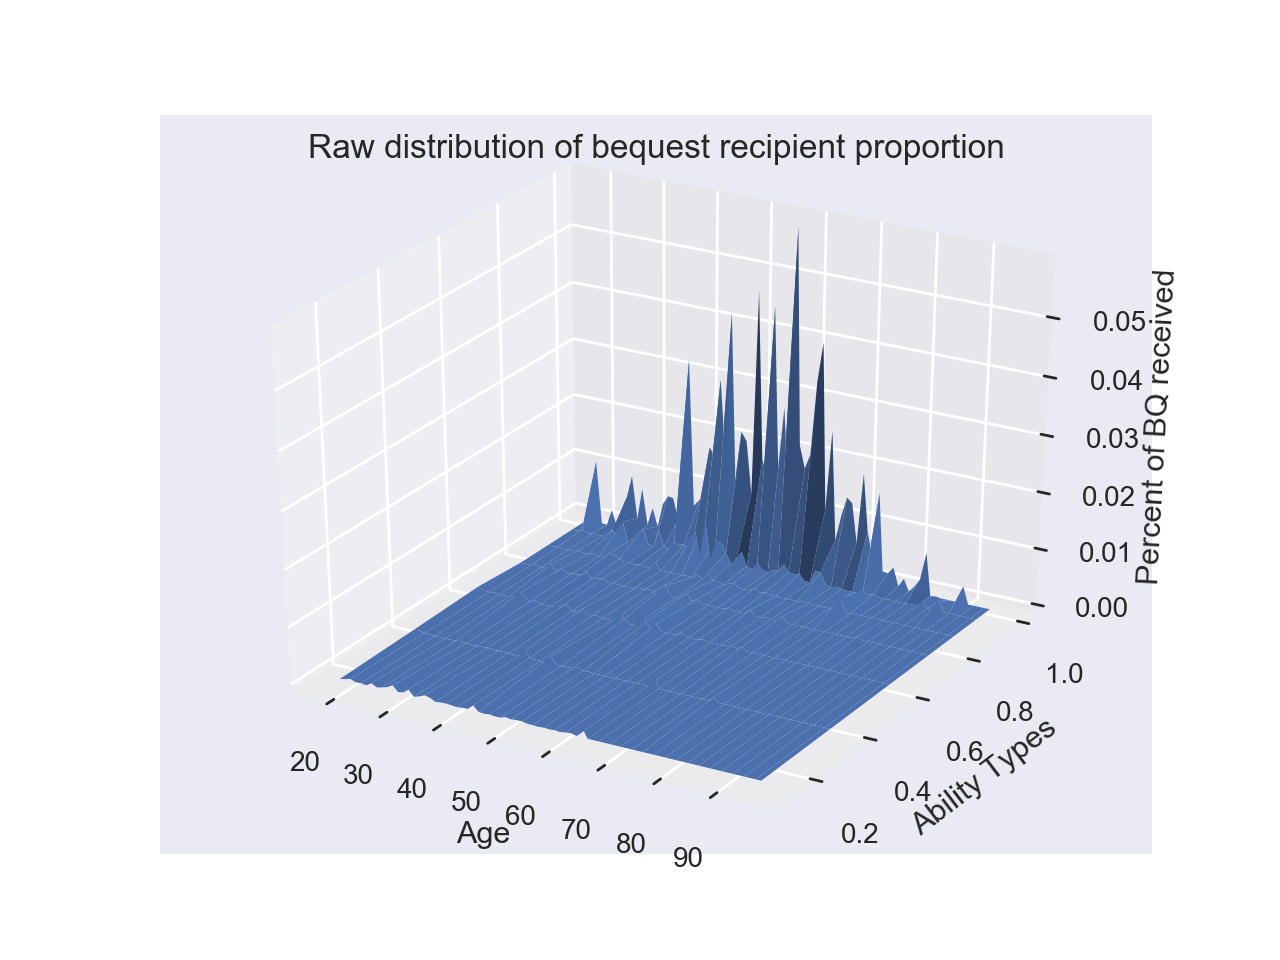

Text(0.5,0,'Percent of BQ received')

In [14]:
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=78),
       error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [7]:
grid.best_params_

{'bandwidth': 0.1}

I choose 0.1, the best parameter suggested by resampling, as bandwidth.

In [9]:
abils_vec = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(abils_vec, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

In [10]:
from scipy.stats import gaussian_kde
bandwidth = 0.1
kde_object = gaussian_kde(data, bandwidth)

<IPython.core.display.Javascript object>


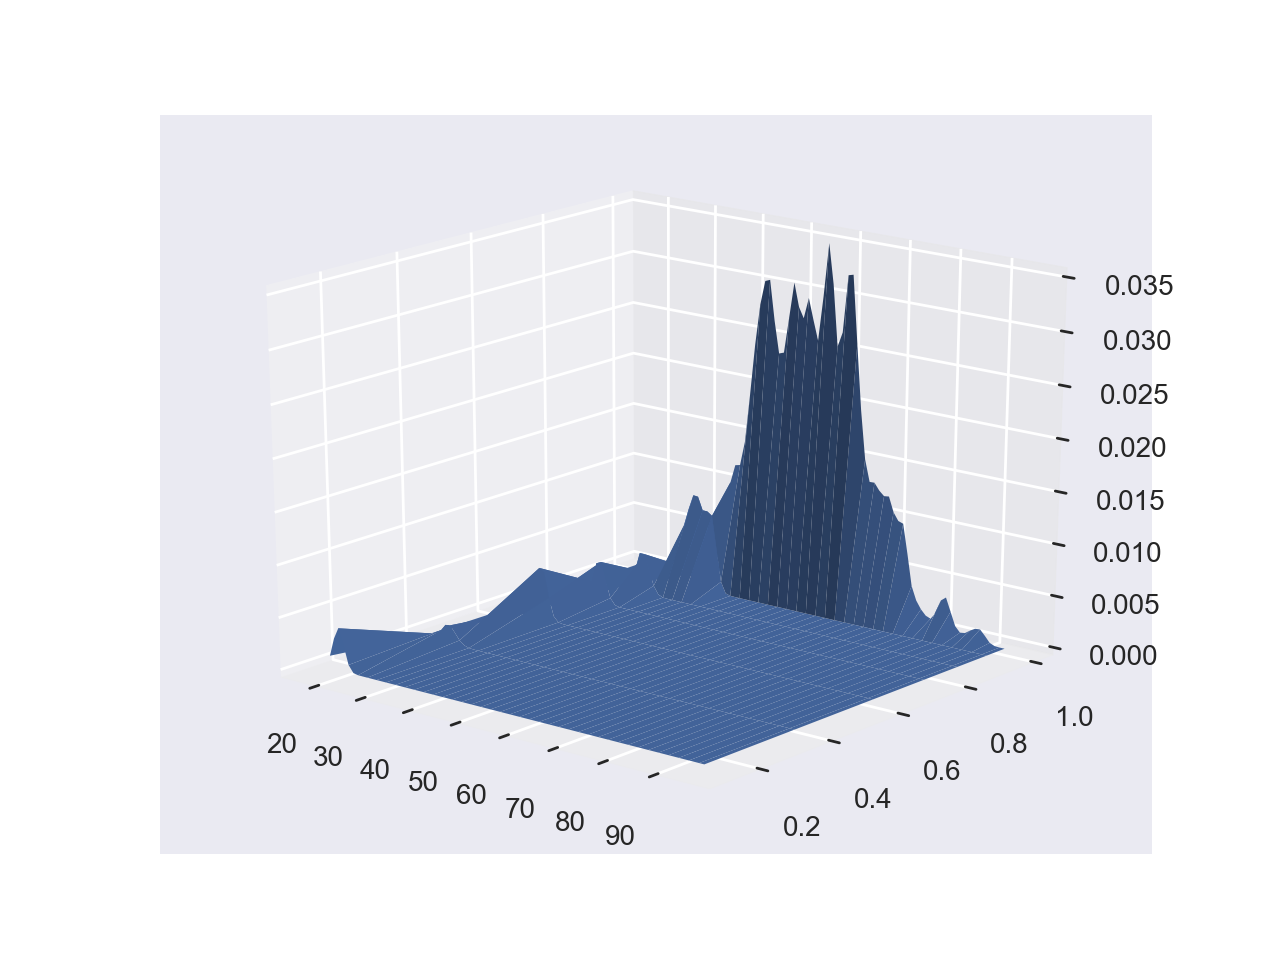

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQkde_scaled)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is:

In [13]:
BQkde_scaled[61-18-1, 5]

1.6291180220431175e-06